In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio
import glob
import os
import scipy.io

from keras.utils import to_categorical #for one hot encoding

#To make it compatible with jupyter notebook
%matplotlib inline
# Fixing random state for reproducibility
np.random.seed(1)

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset Preparation:

In [2]:
%run "Dataset_generator.ipynb"

In [3]:
def print_shapes_of_dataset():
    print("Train X shape: \t" + str(train_set_X.shape))  #can make (60000, 28, 28, 1) but i think there is no need
    print("Train Y shape: \t" + str(train_set_Y.shape))
    print("Test X shape: \t" + str(test_set_X.shape))
    print("Test Y shape: \t" + str(test_set_Y.shape))
print_shapes_of_dataset()

Train X shape: 	(60000, 28, 28)
Train Y shape: 	(60000, 1)
Test X shape: 	(10000, 28, 28)
Test Y shape: 	(10000, 1)


In [4]:
train_set_Y = train_set_Y.T
test_set_Y = test_set_Y.T

In [5]:
print_shapes_of_dataset()

Train X shape: 	(60000, 28, 28)
Train Y shape: 	(1, 60000)
Test X shape: 	(10000, 28, 28)
Test Y shape: 	(1, 10000)


Label: 	7


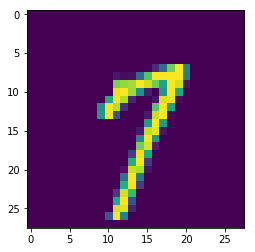

In [6]:
def visualize_img_from_trainset (index = 30800):
    print("Label: \t" + str(train_set_Y[0, index]))
    plt.imshow(train_set_X[index])
visualize_img_from_trainset (index = 30800)

## Loading Filters

In [7]:
#loading data from a mat file
data = scipy.io.loadmat('filters.mat')
filters = data['filters']
filters = np.array(filters)
print(filters.shape)

(17, 17, 36)


In [8]:
def visulize_filters(filters, columns = 6, rows = 6):
    fig = plt.figure(figsize=(20, 30))

    for i in range(1, columns*rows +1):
        img = filters[:, :, i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

In [9]:
# visulize_filters(filters)

## Convolution Functions:

In [10]:
def conv_single_step(img_patch, in_filter):
    '''
    returns:
        conv - image_patch * filter
    '''
    conv = np.dot(np.flip(img_patch.flatten(), axis = 0), in_filter.flatten())
    
    return conv

In [11]:
def conv_forward(img, filters, stride = 1, pad = 0):
    '''
    
    '''
    conv_mat = None
    img_rows = img.shape[0]
    img_cols = img.shape[1]
    flt_rows = filters.shape[0]
    flt_cols = filters.shape[1]
    flt_count = filters.shape[2]
    
    n_h = int((img_rows - flt_rows + (2*pad))/stride) + 1
    n_w = int((img_cols - flt_cols + (2*pad))/stride) + 1
    n_c = flt_count
    conv_mat = np.zeros((n_h, n_w, n_c))
    '''
    print("conv rows:\t" + str(conv_mat.shape[0]))
    print("conv cols:\t" + str(conv_mat.shape[1]))
    print("conv depth:\t" + str(conv_mat.shape[2]))
    '''
    for i in range(0, n_c): #for filters
        for j in range(0, n_h): #for image rows
            for k in range(0, n_w): #for image cols
                conv_mat[j, k, i] = conv_single_step(img[j:(j+flt_rows), k:(k+flt_cols)], filters[:, :, i])
    return conv_mat

In [12]:
def conv_forward_all(images, filters, stride = 1, pad = 0):
    
    img_count = images.shape[0]
    img_rows = images.shape[1]
    img_cols = images.shape[2]
    flt_rows = filters.shape[0]
    flt_cols = filters.shape[1]
    flt_count = filters.shape[2]
    
    n_h = int((img_rows - flt_rows + (2*pad))/stride) + 1
    n_w = int((img_cols - flt_cols + (2*pad))/stride) + 1
    n_c = flt_count
    conv_all = np.zeros((img_count, n_h, n_w, n_c))
    
    for i in range(0, images.shape[0]):
        print("convolving the example:\t" + str(i))
        conv_all[i, :,:,:] = conv_forward(images[i, :, :], filters, stride, pad)
        
    
    return conv_all
    

## Pooling Functions

In [13]:
def pool_forward(feature_map, mode = "max", filter_size = 2, stride = 2):
    
    n_c = feature_map.shape[2]
    f_rows = feature_map.shape[0]
    f_cols = feature_map.shape[1]
    
    n_h = int((f_rows - filter_size)/stride) + 1
    n_w = int((f_rows - filter_size)/stride) + 1
    
    poolout = np.zeros((n_h, n_w, n_c))
    
    if (mode == "max"):
        for c in range(0, n_c):
            for i in range(0, n_h):
                for j in range(0, n_w):
                    pool_max = np.amax(feature_map[(i*stride):((i*stride)+filter_size), (j*stride):((j*stride)+filter_size),c])
                    poolout[i, j, c] = pool_max
    else:
        print("Wrong Way bro")
    return poolout

In [14]:
def pool_forward_all(input_mat, mode = "max", filter_size = 2, stride = 2):
    
    
    n_count = input_mat.shape[0]
    n_c = input_mat.shape[3]
    f_rows = input_mat.shape[1]
    f_cols = input_mat.shape[2]
    
    n_h = int((f_rows - filter_size)/stride) + 1
    n_w = int((f_rows - filter_size)/stride) + 1
    
    poolout = np.zeros((n_count, n_h, n_w, n_c))
    
    for i in range(0, n_count):
        print ("pool the example:\t" + str(i))
        poolout[i, :, :, :] = pool_forward(input_mat[i,:,:,:])
        

    return poolout

# FC Layers Functions

In [15]:
# %run FC_Layer_functions.ipynb

In [16]:
def init_network(no_of_layers, input_dim, neurons_per_layer):
    '''
    no_of_layers: count
    input_dim: m
    neurons_per_layer: list in order L1, L2, L3 ... Lout
    
    returns:
    net:    dict instance
    '''
    net = {
        "no_of_layers": no_of_layers,
        "W1": np.random.randn(neurons_per_layer[0], input_dim)*0.01,
        "b1": np.zeros((neurons_per_layer[0], 1))
    }
    
    for i in range(1, no_of_layers):
        net["W"+str(i+1)] = np.random.randn(neurons_per_layer[i], neurons_per_layer[i-1])*0.01
        net["b"+str(i+1)] = np.zeros((neurons_per_layer[i], 1))

    return net

In [17]:
def sigmoid (x):
    '''
    Parameters:
    x - input
    
    Returns:
    answer - The sigmoid vaue of 'x'
    '''
    answer = 1/(1 + np.exp(-x))
    return answer

In [10]:
def ReLU(x):
    
    
    return np.maximum(np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3])), x)

In [19]:
def softmax(Z):
    A = []
    exp_Z = []
    for i in range(0, Z.shape[0]):
        exp_Z.append(np.exp(Z[i, :]))
    
    exp_Z = np.array(exp_Z)
    sum_exp_Z = np.sum(exp_Z, axis = 0, keepdims = True)
    
    for i in range(0, Z.shape[0]):
        ans = (exp_Z[i, :] / sum_exp_Z)
        A.append(ans)
    
    A = np.array(A)
    A = A.reshape((A.shape[0], A.shape[2]))
    return A

In [20]:
def  forwardPropagation (A_prev, W, b, activation):
    '''
    Parameters:
    model = perceptron class instance, where it is the model initialized using initializeParameters
    X =     [[all dim1 vals], [all dim2 vals]]    i.e.inputs stacked vertically

    Returns:
    modelOutput = The class instance with 'x', 'Z1', 'A1' and 'Z2', 'A2' in it
    '''
    
    Z = np.dot(W, A_prev) + b
    
    if(activation == "sigmoid"):
        A = sigmoid(Z)
    elif(activation == "softmax"):
        A = softmax(Z)
    else:
        print("wrong activation")
        
    return A, Z

In [21]:
def feedForward(net, X):
    '''
    net:   
    X:     
    
    return:
    net:       
    '''
    no_of_layers = net["no_of_layers"]
    net["X"] = X
    
    A_prev = X
    activation = "sigmoid"
    
    for i in range(1, no_of_layers):
        W = net["W"+str(i)]
        b = net["b"+str(i)]
        net["AL"+str(i)], net["ZL"+str(i)] = forwardPropagation (A_prev, W, b, activation)
        A_prev = net["AL"+str(i)]
    
    W = net["W"+str(no_of_layers)]
    b = net["b"+str(no_of_layers)]
    net["AL"+str(no_of_layers)], net["ZL"+str(no_of_layers)] = forwardPropagation (A_prev, W, b, activation = "softmax")
        
    return net

In [22]:
def CostCalculation(m, net_out, Y):
    '''
    net_out:  
    Y: ground truth
    
    reutrn:
    cost
    '''
    
    # one hot encode
    encoded_Y = to_categorical(Y)
    encoded_Y = encoded_Y.reshape(encoded_Y.shape[1], encoded_Y.shape[2])
    encoded_Y = encoded_Y.T
    
    cost = (1/(2*m)) * np.sum(np.power(abs(encoded_Y - net_out), 2), axis = 1, keepdims = True)
    
    return cost

In [23]:
def BackProp(net, Y):
    '''
    parms:
    net =  dict
    Y =    GT
    
    returns:
    gradients =   
    '''
    gradients = {}
    no_of_layers = net["no_of_layers"]
    
    # one hot encode
    encoded_Y = to_categorical(Y)
    encoded_Y = encoded_Y.reshape(encoded_Y.shape[1], encoded_Y.shape[2])
    encoded_Y = encoded_Y.T
    m = encoded_Y.shape[1]
    W = net["W"+str(no_of_layers)]
    b = net["b"+str(no_of_layers)]
    Z = net["ZL"+str(no_of_layers)]
    A = net["AL"+str(no_of_layers)]
    
    dZ = (A - encoded_Y) * (A*(1-A))
    
    dW = (1/m)*(np.dot(dZ, net["AL"+str(no_of_layers-1)].T))
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    gradients["dW"+str(no_of_layers)] = dW
    gradients["db"+str(no_of_layers)] = db
    
    for i in range(1, no_of_layers-1):
        dZ = np.dot(net["W"+str(no_of_layers -i+1)].T, dZ) * (net["AL"+str(no_of_layers -i)] - (net["AL"+str(no_of_layers -i)]*net["AL"+str(no_of_layers -i)]))
        dW = (1/m)*(np.dot(dZ, net["AL"+str(no_of_layers -i-1)].T))
        db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
        gradients["dW"+str(no_of_layers -i)] = dW
        gradients["db"+str(no_of_layers -i)] = db
    
    i = no_of_layers - 1    
    dZ = np.dot(net["W"+str(no_of_layers -i+1)].T, dZ) * (net["AL"+str(no_of_layers -i)] - (net["AL"+str(no_of_layers -i)]*net["AL"+str(no_of_layers -i)]))
    dW = (1/m)*(np.dot(dZ, net["X"].T))
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    gradients["dW"+str(no_of_layers -i)] = dW
    gradients["db"+str(no_of_layers -i)] = db
    
    
    return gradients

In [24]:
def  weightUpdate (net, gradients, lr_rate):
    '''
    
    '''
    
    no_of_layers = net["no_of_layers"]
    
    for i in range(1, no_of_layers+1):
        net["W"+str(i)] = net["W"+str(i)] - (lr_rate * gradients["dW"+str(i)])
        net["b"+str(i)] = net["b"+str(i)] - (lr_rate * gradients["db"+str(i)])
        

    return net

In [25]:
def train_Model(net, train_X, train_Y, test_X, test_Y, numberofEpochs = 100, lr_rate = 0.1):
    '''
    
    '''
    
    #after flatten
    no_of_layers = net["no_of_layers"]
    All_Train_Loss = []
    All_Test_Loss = []
    
    m = train_X.shape[1]
    
    
    for i in range(1, numberofEpochs+1):
        trn_net = feedForward(net, train_X)
        trn_loss = CostCalculation(train_X.shape[1], trn_net["AL"+str(no_of_layers)], train_Y)
        All_Train_Loss.append((1/10)*np.sum(trn_loss, axis = 0, keepdims = True))
        
        trn_grads = BackProp(trn_net, train_Y)
        net = weightUpdate(trn_net, trn_grads, lr_rate)    
        
        tst_net = feedForward(net, test_X)
        tst_loss = CostCalculation(test_X.shape[1], tst_net["AL"+str(no_of_layers)], test_Y)
        All_Test_Loss.append((1/10)*np.sum(tst_loss, axis = 0, keepdims = True))
        
        if((i%50 == 0) or (i in range(1, 10+1))):
            print("epoch #"+ str(i) + ": \tTrain Loss = "+ str(All_Train_Loss[-1]) + "\t\t Validation Loss = " + str(All_Test_Loss[-1]))
    
    out = {
        "net": net,
        "All_Train_Loss": All_Train_Loss,
        "All_Test_Loss": All_Test_Loss
    }
    return out

In [26]:
def Train_Model(net, train_X, train_Y, test_X, test_Y, filters, numberofEpochs = 100, lr_rate = 0.1):
    '''
    
    '''
    # Covolving train_X+test_X
    #on train set
    if os.path.isfile("conv_all_train_X.npz"): 
        npzfile = np.load("conv_all_train_X.npz")
        train_X_conv = npzfile['out']
    else:
        train_X_conv = conv_forward_all(train_X, filters)
        np.savez("conv_all_train_X.npz", out = train_X_conv)

    #on test set

    if os.path.isfile("conv_all_test_X.npz"): 
        npzfile = np.load("conv_all_test_X.npz")
        test_X_conv = npzfile['out']
    else:
        test_X_conv = conv_forward_all(test_X, filters)
        np.savez("conv_all_test_X.npz", out = test_X_conv)
    
    #pool train_X+test_X
    #on train set
    if os.path.isfile("pool_all_train_X.npz"): 
        npzfile = np.load("pool_all_train_X.npz")
        train_X_conv_pool = npzfile['out']
    else:
        train_X_conv_pool = pool_forward_all(train_X_conv)
        np.savez("pool_all_train_X.npz", out = train_X_conv_pool)

    #on test set
    if os.path.isfile("pool_all_test_X.npz"): 
        npzfile = np.load("pool_all_test_X.npz")
        test_X_conv_pool = npzfile['out']
    else:
        test_X_conv_pool = pool_forward_all(test_X_conv)
        np.savez("pool_all_test_X.npz", out = test_X_conv_pool)
    
    #Apply ReLU
    #train
    train_X_conv_pool_relu = ReLU(train_X_conv_pool)
    
    #test
    test_X_conv_pool_relu = ReLU(test_X_conv_pool)
    
    #flatten train_X+test_X
    train_X_conv_pool_flatten = train_X_conv_pool.reshape(train_X_conv_pool.shape[0], -1).T
    test_X_conv_pool_flatten = test_X_conv_pool.reshape(test_X_conv_pool.shape[0], -1).T
    
    #after flatten
    no_of_layers = net["no_of_layers"]
    All_Train_Loss = []
    All_Test_Loss = []
    
    m = train_Y.shape[1]
    
    
    for i in range(1, numberofEpochs+1):
        trn_net = feedForward(net, train_X_conv_pool_flatten)
        trn_loss = CostCalculation(train_X_conv_pool_flatten.shape[1], trn_net["AL"+str(no_of_layers)], train_Y)
        All_Train_Loss.append((1/10)*np.sum(trn_loss, axis = 0, keepdims = True))
        
        trn_grads = BackProp(trn_net, train_Y)
        net = weightUpdate(trn_net, trn_grads, lr_rate)    
        
        #below was expected tobe done in test() function
        tst_net = feedForward(net, test_X)
        tst_loss = CostCalculation(test_X.shape[1], tst_net["AL"+str(no_of_layers)], test_Y)
        All_Test_Loss.append((1/10)*np.sum(tst_loss, axis = 0, keepdims = True))
        
        if((i%50 == 0) or (i in range(1, 10+1))):
            print("epoch #"+ str(i) + ": \tTrain Loss = "+ str(All_Train_Loss[-1]) + "\t\t Validation Loss = " + str(All_Test_Loss[-1]))
    
    out = {
        "net": net,
        "All_Train_Loss": All_Train_Loss,
        "All_Test_Loss": All_Test_Loss
    }
    return out

# Using above Functions for demo

## Conv layer 

In [2]:
#on train set
if os.path.isfile("conv_all_train_X.npz"): 
    npzfile = np.load("conv_all_train_X.npz")
    train_set_X_conv = npzfile['out']
else:
    train_set_X_conv = conv_forward_all(train_set_X, filters)
    np.savez("conv_all_train_X.npz", out = train_set_X_conv)

#on test set

if os.path.isfile("conv_all_test_X.npz"): 
    npzfile = np.load("conv_all_test_X.npz")
    test_set_X_conv = npzfile['out']
else:
    test_set_X_conv = conv_forward_all(test_set_X, filters)
    np.savez("conv_all_test_X.npz", out = test_set_X_conv)

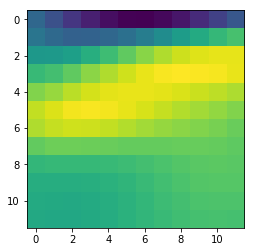

In [6]:
plt.imshow(train_set_X_conv[30800, :, :, 0])

## Pool layer

In [3]:
#on train set
if os.path.isfile("pool_all_train_X.npz"): 
    npzfile = np.load("pool_all_train_X.npz")
    train_set_X_conv_pool = npzfile['out']
else:
    train_set_X_conv_pool = pool_forward_all(train_set_X_conv)
    np.savez("pool_all_train_X.npz", out = train_set_X_conv_pool)
    
#on test set
if os.path.isfile("pool_all_test_X.npz"): 
    npzfile = np.load("pool_all_test_X.npz")
    test_set_X_conv_pool = npzfile['out']
else:
    test_set_X_conv_pool = pool_forward_all(test_set_X_conv)
    np.savez("pool_all_test_X.npz", out = test_set_X_conv_pool)

In [4]:
print(train_set_X_conv_pool.shape)
print(test_set_X_conv_pool.shape)

(60000, 6, 6, 36)
(10000, 6, 6, 36)


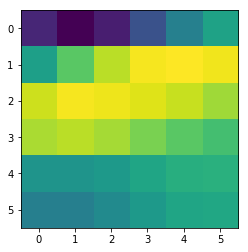

In [7]:
plt.imshow(train_set_X_conv_pool[30800, :, :, 0])

## ReLU Layer

In [11]:
#Apply ReLU
    #train
train_X_conv_pool_relu = ReLU(train_set_X_conv_pool)
    #test
test_X_conv_pool_relu = ReLU(test_set_X_conv_pool)

In [12]:
print(train_X_conv_pool_relu.shape)
print(test_X_conv_pool_relu.shape)

(60000, 6, 6, 36)
(10000, 6, 6, 36)


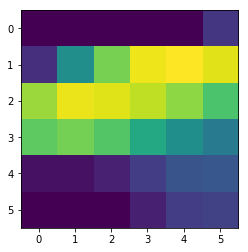

In [13]:
plt.imshow(train_X_conv_pool_relu[30800, :, :, 0])

## Flatten conv+pool output

In [32]:
train_set_X_conv_pool_flatten = train_X_conv_pool_relu.reshape(train_X_conv_pool_relu.shape[0], -1).T
test_set_X_conv_pool_flatten = test_X_conv_pool_relu.reshape(test_X_conv_pool_relu.shape[0], -1).T

In [33]:
print("After Flatten")
print("train_set_X_conv_pool_flatten.shape: \t" + str(train_set_X_conv_pool_flatten.shape))
print("train_set_Y.shape: \t" + str(train_set_Y.shape))
print("test_set_X_conv_pool.shape: \t" + str(test_set_X_conv_pool_flatten.shape))
print("test_set_Y.shape: \t" + str(test_set_Y.shape))

After Flatten
train_set_X_conv_pool_flatten.shape: 	(1296, 60000)
train_set_Y.shape: 	(1, 60000)
test_set_X_conv_pool.shape: 	(1296, 10000)
test_set_Y.shape: 	(1, 10000)


## Train FC layers

In [87]:
# Model = init_network(no_of_layers = 3, input_dim = train_set_X_conv_pool_flatten.shape[0], neurons_per_layer = [100, 50, 10])
# Out = train_Model(Model, train_set_X_conv_pool_flatten, train_set_Y, test_set_X_conv_pool_flatten, test_set_Y, numberofEpochs = 1500, lr_rate = 0.1)

In [88]:
'''

#For visualizing the losses throughout training
TrainLosses = Out["All_Train_Loss"]
TestLosses = Out["All_Test_Loss"]

plt.figure(figsize=(20,10))
x1 = np.arange(1, len(TrainLosses)+1)
y1 = np.array(TrainLosses)
x1.shape = (x1.shape[0], 1)
y1.shape = (y1.shape[0], 1)

x2 = np.arange(1, len(TestLosses)+1)
y2 = np.array(TestLosses)
x2.shape = (x2.shape[0], 1)
y2.shape = (y2.shape[0], 1)

#plt.title("Following Plot is for hidden units = "+ str(hu)+ " \t Learning Rate = "+str(lr))
plt.plot(x1, y1, label="Train Loss")
plt.plot(x2, y2, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

print("first: \t Train = " + str(TrainLosses[0]) + "\t\t Val:" + str(TestLosses[0]))
print("Last: \t Train = " + str(TrainLosses[-1]) + "\t\t Val:" + str(TestLosses[-1]))
print("Difference: \t Train = " + str(TrainLosses[-1] - TrainLosses[0]) + "\t\t Val:" + str(TestLosses[-1] - TestLosses[0]))

plt.show()
#plt.savefig("./images/Task02/hu_"+str(hu)+"_lr_"+str(lr))
'''

'\n\n#For visualizing the losses throughout training\nTrainLosses = Out["All_Train_Loss"]\nTestLosses = Out["All_Test_Loss"]\n\nplt.figure(figsize=(20,10))\nx1 = np.arange(1, len(TrainLosses)+1)\ny1 = np.array(TrainLosses)\nx1.shape = (x1.shape[0], 1)\ny1.shape = (y1.shape[0], 1)\n\nx2 = np.arange(1, len(TestLosses)+1)\ny2 = np.array(TestLosses)\nx2.shape = (x2.shape[0], 1)\ny2.shape = (y2.shape[0], 1)\n\n#plt.title("Following Plot is for hidden units = "+ str(hu)+ " \t Learning Rate = "+str(lr))\nplt.plot(x1, y1, label="Train Loss")\nplt.plot(x2, y2, label="Validation Loss")\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.legend(loc=\'best\')\n\nprint("first: \t Train = " + str(TrainLosses[0]) + "\t\t Val:" + str(TestLosses[0]))\nprint("Last: \t Train = " + str(TrainLosses[-1]) + "\t\t Val:" + str(TestLosses[-1]))\nprint("Difference: \t Train = " + str(TrainLosses[-1] - TrainLosses[0]) + "\t\t Val:" + str(TestLosses[-1] - TestLosses[0]))\n\nplt.show()\n#plt.savefig("./images/Task02

## Doit in blocks

In [34]:
net = init_network(no_of_layers = 2, input_dim = train_set_X_conv_pool_flatten.shape[0], neurons_per_layer = [1000, 10])

In [35]:
no_of_layers = net["no_of_layers"]
All_Train_Loss = []
All_Test_Loss = []    

In [85]:
train_X_chunk = train_set_X_conv_pool_flatten[:, 0:30000]
train_Y_chunk = train_set_Y[:, 0:30000]

test_X_chunk = test_set_X_conv_pool_flatten[:, :]
test_Y_chunk = test_set_Y[:, :]

In [86]:
print(train_X_chunk.shape)
print(train_Y_chunk.shape)
print(test_X_chunk.shape)
print(test_Y_chunk.shape)

(1296, 30000)
(1, 30000)
(1296, 10000)
(1, 10000)


In [38]:
numberofEpochs = 500
lr_rate = 0.1
for i in range(1, numberofEpochs+1):
        trn_net = feedForward(net, train_X_chunk)
        trn_loss = CostCalculation(train_Y_chunk.shape[1], trn_net["AL"+str(no_of_layers)], train_Y_chunk)
        All_Train_Loss.append((1/10)*np.sum(trn_loss, axis = 0, keepdims = True))
        
        trn_grads = BackProp(trn_net, train_Y_chunk)
        net = weightUpdate(trn_net, trn_grads, lr_rate)    
        
        #below was expected tobe done in test() function
        tst_net = feedForward(net, test_X_chunk)
        tst_loss = CostCalculation(test_Y_chunk.shape[1], tst_net["AL"+str(no_of_layers)], test_Y_chunk)
        All_Test_Loss.append((1/10)*np.sum(tst_loss, axis = 0, keepdims = True))
        
        if((i%50 == 0) or (i in range(1, 10+1))):
            print("epoch #"+ str(i) + ": \tTrain Loss = "+ str(All_Train_Loss[-1]) + "\t\t Validation Loss = " + str(All_Test_Loss[-1]))
    

epoch #1: 	Train Loss = [[0.04525965]]		 Validation Loss = [[0.04426318]]
epoch #2: 	Train Loss = [[0.04426759]]		 Validation Loss = [[0.04322229]]
epoch #3: 	Train Loss = [[0.04324812]]		 Validation Loss = [[0.04207818]]
epoch #4: 	Train Loss = [[0.04213047]]		 Validation Loss = [[0.04082419]]
epoch #5: 	Train Loss = [[0.04090607]]		 Validation Loss = [[0.03949226]]
epoch #6: 	Train Loss = [[0.03960304]]		 Validation Loss = [[0.03813267]]
epoch #7: 	Train Loss = [[0.03826906]]		 Validation Loss = [[0.03678452]]
epoch #8: 	Train Loss = [[0.03694359]]		 Validation Loss = [[0.03547713]]
epoch #9: 	Train Loss = [[0.03565661]]		 Validation Loss = [[0.03422773]]
epoch #10: 	Train Loss = [[0.03442531]]		 Validation Loss = [[0.03304445]]
epoch #50: 	Train Loss = [[0.01569163]]		 Validation Loss = [[0.01507935]]
epoch #100: 	Train Loss = [[0.01133926]]		 Validation Loss = [[0.0108432]]
epoch #150: 	Train Loss = [[0.00947387]]		 Validation Loss = [[0.00898469]]
epoch #200: 	Train Loss = [[0.008

first: 	 Train = [[0.04525965]]		 Val:[[0.04426318]]
Last: 	 Train = [[0.00583274]]		 Val:[[0.00549727]]
Difference: 	 Train = [[-0.03942691]]		 Val:[[-0.03876592]]


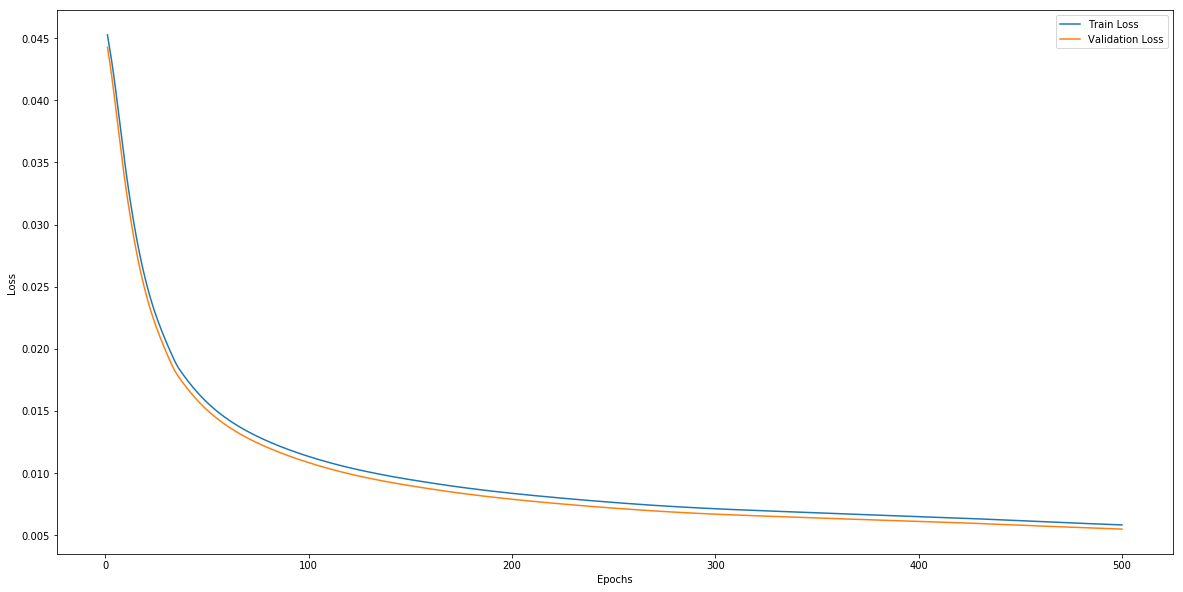

In [39]:
#For visualizing the losses throughout training
TrainLosses = All_Train_Loss
TestLosses = All_Test_Loss

plt.figure(figsize=(20,10))
x1 = np.arange(1, len(TrainLosses)+1)
y1 = np.array(TrainLosses)
x1.shape = (x1.shape[0], 1)
y1.shape = (y1.shape[0], 1)

x2 = np.arange(1, len(TestLosses)+1)
y2 = np.array(TestLosses)
x2.shape = (x2.shape[0], 1)
y2.shape = (y2.shape[0], 1)

#plt.title("Following Plot is for hidden units = "+ str(hu)+ " \t Learning Rate = "+str(lr))
plt.plot(x1, y1, label="Train Loss")
plt.plot(x2, y2, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

print("first: \t Train = " + str(TrainLosses[0]) + "\t\t Val:" + str(TestLosses[0]))
print("Last: \t Train = " + str(TrainLosses[-1]) + "\t\t Val:" + str(TestLosses[-1]))
print("Difference: \t Train = " + str(TrainLosses[-1] - TrainLosses[0]) + "\t\t Val:" + str(TestLosses[-1] - TestLosses[0]))

plt.show()
#plt.savefig("./images/Task02/hu_"+str(hu)+"_lr_"+str(lr))


In [41]:
#check parms
for i in range(1, net["no_of_layers"] +1):
    print("W"+str(i)+".shape:\t"+str(net["W"+str(i)].shape))
    
#check parms
for i in range(1, net["no_of_layers"] +1):
    print("b"+str(i)+".shape:\t"+str(net["b"+str(i)].shape))

W1.shape:	(1000, 1296)
W2.shape:	(10, 1000)
b1.shape:	(1000, 1)
b2.shape:	(10, 1)


## Save/load network weights

In [42]:
np.savez("net_weights.npz", W1 = net["W1"], W2 = net["W2"], b1 = net["b1"], b2 = net["b2"])

In [44]:
npzfile = np.load("net_weights.npz")
W1 = npzfile["W1"]
W2 = npzfile["W2"]
b1 = npzfile["b1"]
b2 = npzfile["b2"]

## Accuracy Calculation

In [82]:
test_net = feedForward(net, test_X_chunk)    

In [83]:
T_count = 0
for i in range(0, test_Y_chunk.shape[1]):
    max_value = np.amax(output_layer[:, i])
    for j in range(0, 10):
        if (max_value == output_layer[j, i]):
            pred_label = j
    
    if (pred_label == test_Y_chunk[0, i]):
        T_count = T_count+1

In [84]:
print("True predictions:\t"+ str(T_count))
print("Accuracy:\t"+    str(T_count/test_Y_chunk.shape[1]))

True predictions:	9629
Accuracy:	0.9629
